# Advanced Usage

This notebook will focus on some of the more complicated ways I have used TelFit in the past. The first thing will be generating a self-consistent fit to a full echelle spectrum. The most accurate way to do that is to simply loop over the orders, letting TelFit find the best parameters each time. However, if you want a self-consistent fit or want to go a bit faster, you can follow this approach:

1. Fit the several orders that are dominated by water lines
2. Fix the humidity to the average best-fit humidity 
3. Repeat steps 1-2 for any other molecules present (typically CO, CO2, N2O)
4. Generate a model spectrum for each order with the best-fit parameters.

I'll go back to the A-star spectrum to demonstrate this case

In [1]:
# Standard import block
from astropy.io import fits
import telfit
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_context('notebook', font_scale=1.5)
    sns.set_style('whitegrid')
except ImportError:
    pass

%matplotlib inline

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Read in the data
hdulist = fits.open('../data/HIP_105891.fits')
orders = []
for hdu in hdulist[1:]:
    wl = hdu.data['wavelength']
    fl = hdu.data['flux']
    cont = hdu.data['continuum']
    error = hdu.data['error']
    data = telfit.DataStructures.xypoint(x=wl, y=fl, cont=cont, err=error)
    orders.append(data.copy())


In [3]:
# Initialize the fitter
fitter = telfit.TelluricFitter()
fitter.SetObservatory('McDonald')

# Get relevant info from the fits header. Note that I put these keys there...
header = fits.getheader('../data/HIP_105891.fits')
RH = header['HUMIDITY']
T_fahrenheit = header['AIRTEMP']
temperature = (T_fahrenheit - 32.0) * 5.0 / 9.0 + 273.15
P = header['BARPRESS'] * 33.77
angle = header['ZD']

# Tell TelFit about the values
fitter.AdjustValue(dict(temperature=temperature, pressure=P, angle=angle, resolution=45000))
fitter.FitVariable(dict(h2o=RH))
fitter.SetBounds(dict(h2o=(1, 99), co2=(100, 1000), ch4=(0.1, 10), 
                      n2o=(0.05, 5), co=(0.01, 1.0), resolution=(35000, 55000)))


For the most part, the setup is identical to the setup for fitting a single echelle order. What we will do next, however, fit each molecule separately for a few orders each. **This will take quite a while to run, so I don't suggest you do this during the tutorial!** 

### Fitting molecules from several echelle orders.


In [4]:
# Define a class that we will use to hold the information for each molecule
class Parameter(object):
    def __init__(self, parname, order_list, guess):
        self.parname = str(parname)
        self.order_list = list(order_list)
        self.guess = float(guess)
        self.fitvals = [] # Will hold the best-fit parameters
        
    @property
    def propdict(self):
        return {self.parname: self.guess}
        
# Make parameters for each molecule
h2o = Parameter(parname='h2o', order_list=(2, 3, 33, 34, 35), guess=RH)
co2 = Parameter(parname='co2', order_list=(7, 8, 9, 10), guess=368.5)
ch4 = Parameter(parname='ch4', order_list=(12, 13, 14, 15), guess=1.8)
n2o = Parameter(parname='n2o', order_list=(30,), guess=0.32)
co = Parameter(parname='co', order_list=(38, 39, 40), guess=0.14)

# Adjust the value for each parameter to its initial guess
for par in (h2o, co2, ch4, n2o, co):
    fitter.AdjustValue(par.propdict)

In [5]:
# Big, slow loop!
for par in (h2o, co2, ch4, co, n2o):
    for ordernum in par.order_list:
        order = orders[ordernum][100:-100]
        fitter.FitVariable(par.propdict)
        fitter.AdjustValue(dict(wavestart=order.x[0]-5, waveend=order.x[-1]+5))
        
        # Perform the fit
        source, model = fitter.Fit(data=order,                   # The data to fit
                                   resolution_fit_mode='SVD',   # This is best for IGRINS data. The other option is 'gauss'
                                   adjust_wave='data',          # Adjust the data wavelengths to match the model, rather than vice versa
                                   continuum_fit_order=4,       # Fit the continuum with a 4th-order polynomial
                                   wavelength_fit_order=3,      # Add a 3rd-order polynomial to the wavelengths
                                   air_wave=True,               # The wavelengths are in air (not vacuum)
                                   fit_source=True)             # Fit the source spectrum with a smoothing spline
        
        # Get the best-fit value
        best_fit = fitter.GetValue(par.parname)
        par.fitvals.append(best_fit)
        
    # Now that we have fit every order, fix the value to be the mean
    par.guess = np.mean(par.fitvals)
    fitter.AdjustValue(par.propdict)
    

Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.94246E+01	True		1 - 99
Warning, 17 of 75255 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.94246E+01	True		1 - 99
Warning, 17 of 75255 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.94246E+01	True		1 - 99
Warning, 17 of 75255 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	3.56925E+01	True		1 - 99
Warning, 24 of 74890 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.25904E+01	True		1 - 99
Warning, 5 of 74197 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fit

In [6]:
for par in (h2o, co2, ch4, co, n2o):
    print(par.parname, par.fitvals)

('h2o', [21.533715385108092, 21.522942669282347, 29.010908491157096, 19.980010952509701, 20.007710629610102])
('co2', [397.56884464457113, 395.16143748946564, 377.44897633247655, 385.01746690269033])
('ch4', [1.8367759046605121, 1.8900395503912688, 1.831072568009787, 1.9170097810105495])
('co', [0.15897104016512367, 0.13798494970937122, 0.10313646334980622])
('n2o', [0.36613589946194619])


In [7]:
import dill
with open('tmp.pkl', 'w') as f:
    dill.dump((h2o, co2, ch4, co, n2o), f)

In [8]:
import dill
with open('tmp.pkl', 'r') as f:
    h2o, co2, ch4, co, n2o = dill.load(f)

### Applying the best-fit values

Now that we have fitted values for each of the molecules, we need to generate a model for each order. We already told TelFit to fix the abundances to the best-fit values, so it is pretty much just a matter of looping through the orders.

In [9]:
model_list = []
source_list = []
data_list = []
for order in orders[2:21]:
    fitter.AdjustValue(dict(wavestart=order.x[0]-5, waveend=order.x[-1]+5))
    fitter.ImportData(order.copy())
    source, model = fitter.GenerateModel(pars=[], separate_source=True)
    source_list.append(source)
    model_list.append(model)
    
    # Get the data too, since we are updating the wavelengths
    data = fitter.data
    data.y *= source.y  #Un-remove the source spectrum
    data_list.append(data)

Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Warning, 2 of 80038 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
Parameter      	Value		Fitting?	Bounds
-----

(0.9, 1.1)

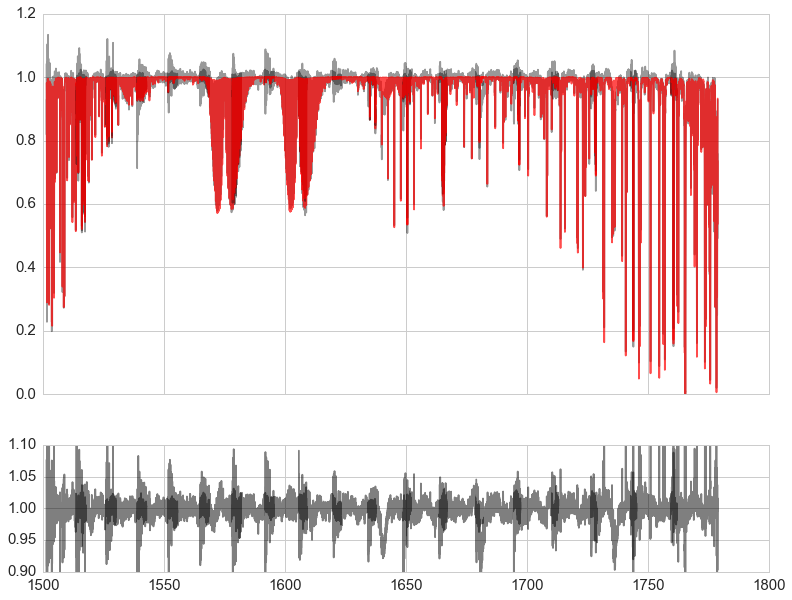

In [10]:
%matplotlib inline
fig, (top, bottom) = plt.subplots(2, 1, sharex=True, figsize=(13,10),
                                  gridspec_kw=dict(height_ratios=(3,1)))
first = 100
last = -100
for data, model in zip(data_list, model_list):
    data = data[first:last].copy()
    model = model[first:last].copy()
    
    top.plot(data.x, data.y/data.cont, 'k-', alpha=0.4)
    top.plot(model.x, model.y, 'r-', alpha=0.7)
    
    bottom.plot(data.x, data.y/data.cont / model.y, 'k-', alpha=0.5)
    
bottom.set_ylim((0.9, 1.1))

## Quick fitting using Beer's Law

All of the fitting I've demonstrated so far uses purely numerical methods (namely, a Levenberg-Marquardt solver) to decide which model to try next. What about using some physics? The fraction of light transmitted through the atmosphere is defined by Beer's Law:

$$ T_i \sim e^{-\sigma \Sigma_i} $$

where $\sigma$ is the cross section of the molecule at the specified wavelength, and $\Sigma$ is the column density of absorbers. If the current model has transmission $T_i$ at a given wavelength, and the data has absorption $T_{\rm true}$ at that wavelength, we can estimate the new column density with Beer's Law:

$$\frac{\log{T_{\rm true}}}{\log{T_i}} = \frac{\Sigma_{i+1}}{\Sigma_{i}} $$

Therefore, the goal is to pick an order that is dominated by a single type of molecule, and fit that molecule with this procedure instead of the generic solver. I will demonstrate that below with an order dominated by water lines. **Discuss transforming from humidity to ppmv and back...**

In [ ]:
for par in (h2o, co2, ch4, co, n2o):
    fitter.AdjustValue(par.propdict)

In [ ]:
from astropy import units as u
fitter.xunits = u.nm

In [ ]:
fitter.GenerateModel??